# Nitorch Tutorial: ADNI Baseline Full Set

## Notebook Setup

### IPython Magic

IPython has a set of predefined 'magic functions'. The '%' is a line-oriented magic function where lines prefixed by the '%' character work similar to OS command-line calls; they get the rest of the line as an argument.


**%matplotlib inline:**  Sets the backend of matplotlib to the 'inline' backend, changing how the plots are displayed and stored so that they are inline with the frontend; stored within the notebook document. 

**%load_ext autoreload:**  Reloads modules automatically before the execution of code. Autoreload has a set of flags you can use to change how it works.

**%autoreload 2:** Reload all modules (except those excluded by %aimport) every time before executing code.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Import All Necessary Modules and Libraries

Make sure you have installed all the necessary python modules in your python environment before running the next cell. In addition, change the 'sys.path.insert(0,"/home/konstantinos/code/ritterlab/nitorch/")' line of code to point to your clone of nitorch.

In [2]:
# dependencies and plotting
import h5py
import os
import sys
import matplotlib.pyplot as plt 
import numpy as np


# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


# sklearn functions
from sklearn.metrics import roc_curve, auc


# load functions from nitorch
sys.path.insert(0,"/home/konstantinos/code/ritterlab/nitorch")
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, IntensityRescale 
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.metrics import binary_balanced_accuracy, sensitivity, specificity
from nitorch.utils import count_parameters

### Torch and CUDA Versions

Make sure you have the approriate version of CUDA installed for your system. Right now the machines in our lab run CUDA 9.2 and so our torch version is '1.7.0+cu92'; Nitorch ... .

In [3]:
torch.__version__

'1.7.0+cu92'

## Prepare Dataset

### Declare Variables for Torch Functions and Dataset

Here we specify the GPU with CUDA, the batch size, and the datatype. **Note:** if CUDA runs out of memory, try a smaller batch size or a different GPU with CUDA.

In [4]:
gpu = 2
b = 4
dtype = np.float64

### Load Masks/Transforms and the Prepare the Dataset for torch

In this example, no mask is used.

Make sure the paths to the correct data set are used. This example uses the ADNI dataset prepared by Fabian Eitel. TODO: (Link to next tutorial)

In [5]:
train_h5 = h5py.File("/ritter/share/data/ADNI_HDF5/Splits_Eitel/train_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_reducedValSize.h5", 'r')
val_h5 = h5py.File("/ritter/share/data/ADNI_HDF5/Splits_Eitel/val_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_reducedValSize.h5", 'r')
test_h5 = h5py.File("/ritter/share/data/ADNI_HDF5/Splits_Eitel/holdout_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_reducedValSize.h5", 'r')

**Split the Dataset**

Here we split our data into training, validation and test sets.

In [6]:
X_train, y_train = train_h5['X'], train_h5['y']
X_val, y_val = val_h5['X'], val_h5['y']
X_test, y_test = test_h5['X'], test_h5['y']

**Dataset Overview:** Binary labels (patients $= 1$, HC $= 0$)

In [7]:
y = np.concatenate([np.array(y_train), np.array(y_val), np.array(y_test)])
print(f"# of patients {np.sum(y)}, # of healthy controls {len(y)-np.sum(y)}")
print(f'lenght of the training set:   {len(y_train)}')
print(f'lenght of the validation set: {len(y_val)}')
print(f'lenght of the holdout set:    {len(y_test)}')
print(f'example label: {y[0]}')
print(f'check the label class: {set(y)} - binary')

# of patients 475, # of healthy controls 494
lenght of the training set:   697
lenght of the validation set: 100
lenght of the holdout set:    172
example label: 1
check the label class: {0, 1} - binary


**Define a Class for the *ADNI Dataset***

Here we define an *ADNIDataset* class that inherits from torch's *Dataset* class. At construction, the class requires inputs and outputs, and we have extended the class to take in optional arguments for image transforms, masks, zoom factors and  datatype. We also redefine the class **len** and **getitem** methods. The new **len** method returns the length of the input vector. The new **getitem** method returns a dictionary with the keys "image" and "label". The image is transformed using the transforms predefined and passed in at construction. The label is also loaded as a tensor. All subclasses should overwrite **getitem** and optionally overwrite **len**. **NOTE:** both inputs and outputs should be in the tensor format in order to use torch with our data.

In [8]:
class ADNIDataset(Dataset):
    """Class for manipulating the ADNI Dataset. Inherits from the torch Dataset class.
    
    Parameters
    ----------
    X
        Input data, i.e MRI images.
    y
        Labels for the data.
    transfrom
        Function for transforming the data into the appropriate format.
    mask
        A mask that can be applied to the data with load_nifti.
    z_factor
        A zoom factor that can be applied to the data with load_nifti.
    dtype
        The desired data type of the data.
        
    """
    def __init__(self, X, y, transform=None, mask=None, z_factor=None, dtype=np.float32):
        """Initialization Process."""
        self.X = X
        self.y = y
        self.transform = transform
        self.mask = mask
        self.z_factor = z_factor
        self.dtype = dtype
        
    def __len__(self):
        """Overwrites the len method.
        
        Returns
        -------
            The length of the input data.
        """
        return len(self.X)
    
    def __getitem__(self, idx):
        """Overwrites the getitem method.
        
        Parameters
        ----------
        idx
            Item index.
            
        Returns
        -------
        sample
            A dictionary containing the transformed image and label as entries.
            
        """
        image = self.X[idx]
        # Convert labels to binary; sometimes labels are not exactly 0 or 1
        label = self.y[idx] >= 0.5 
        label = torch.FloatTensor([label])
        
        if self.transform:
            image = self.transform(image)
            
        sample = {"image" : image, "label" : label}
        return sample

**Define Image Augmentations**

Here we can define augmentations we wish to apply to the data. In this example, we are using a technique called online augmentation. This means that every epoch, our net will see a different dataset. We achieve this by using randomness in our augmentations that are applied to the dataset as we retrieve each item. The aim of this technique is to avoid memorizing the dataset during training and  for our model to generalize well. **NOTE:** Augmentations do not actually increased the dataset size. This is a common misconception. The transformed images still characterize the same information we are trying to extract during learning as the untransformed images.

In [9]:
augmentations = [SagittalFlip(prob=0.5), SagittalTranslate(dist=(-2, 2))]

When instantiating the intances of the dataset class, we also pass in the *transforms* class imported from torchvision. The **.Compose** method allows us to chain transformations that will transform an image when passed in; this happens when we access an item from our dataset class as we have customized the **getitem** function. In addition to the augmentions we defined above, we then define a zero to one intesity normalization transformation and add that to our transformation chain in our **.Compose()** call. **NOTE:** the transformation **ToTensor()** is always the last transformation in our series of transformations so that our data is in the right format for torch. 

**Machine Learning Note:**

When using any type of mask to transform your data into a more desirable format, it is vital to ensure the validity of your results, that you create the mask using **ONLY** the training data, and then apply that same mask to the validation and test sets. If you include all of the data when creating your mask, you run the risk of learning something about the validation and test sets that can artificially inflate your results.

In [10]:
# Define zero to one intensity normalization transformation, training, validation and test set classes
# NOTE: The default setting for intensity transformation is to only apply the transformation to 
#       non-zero entries; this is why we set the masked var to False.
intensity = IntensityRescale(masked=False) 
adni_data_train = ADNIDataset(
    X_train, 
    y_train, 
    transform = transforms.Compose(augmentations + [intensity, ToTensor()]), 
    dtype = dtype
)
adni_data_val = ADNIDataset(
    X_val, y_val, transform=transforms.Compose([intensity, ToTensor()]), dtype=dtype
)
adni_data_test = ADNIDataset(
    X_test, y_test, transform=transforms.Compose([intensity, ToTensor()]), dtype=dtype
)

**Data Visualization**

Lets now take a look at an example of our loaded data. Notice that we have defined a function to nicely display an example of our data. It takes in a subject index and slice indices. **Note:** within the function, when accessing an element of the dataset, it returns a dictionary with "image" as a key; this is how we defined the **getitem** methods. This is the image returned has run through our transformation pipeline.

In [11]:
def visualize_data(dataset = adni_data_train, subject_index = 0, slice_indices = [40, 30, 50]):
    """Displays input images for a dataset using specific subject and slice indices.
    
    Parameters
    ----------
    dataset
        An instance of the ADNIDataset class.
    subject_index
        The index of the desired subject.
    slice_indices
        The indices of the desired slice.
    
    Returns
    -------
    None
    
    """
    sample = dataset[subject_index]
    img = sample["image"]
    print(f"Image shape: {img.shape}")
    print(f"Subject Index: {subject_index}")
    fig = plt.figure(figsize=(15, 15))
    for i, slice_index in enumerate(slice_indices):
        # Transverse, axial, horizontal plane (x-y)
        ax = fig.add_subplot(3, len(slice_indices), i+1)
        ax.set_title(f"Slice Index: {slice_index}")
        ax.imshow(np.rot90(img[0][:,:,slice_index]), cmap='gray')
        # Coronal plane (x-z) 
        ax = fig.add_subplot(3, len(slice_indices), i+4)
        ax.set_title(f"Slice Index: {slice_index}")
        ax.imshow(np.rot90(img[0][:, slice_index, :]), cmap='gray')
        # Sagittal plane (y-z)
        ax = fig.add_subplot(3, len(slice_indices), i+7)
        ax.set_title(f"Slice Index: {slice_index}")
        ax.imshow(np.rot90(img[0][slice_index, :, :]), cmap='gray')
    plt.show()
    plt.show()

Image shape: torch.Size([1, 96, 114, 96])
Subject Index: 400


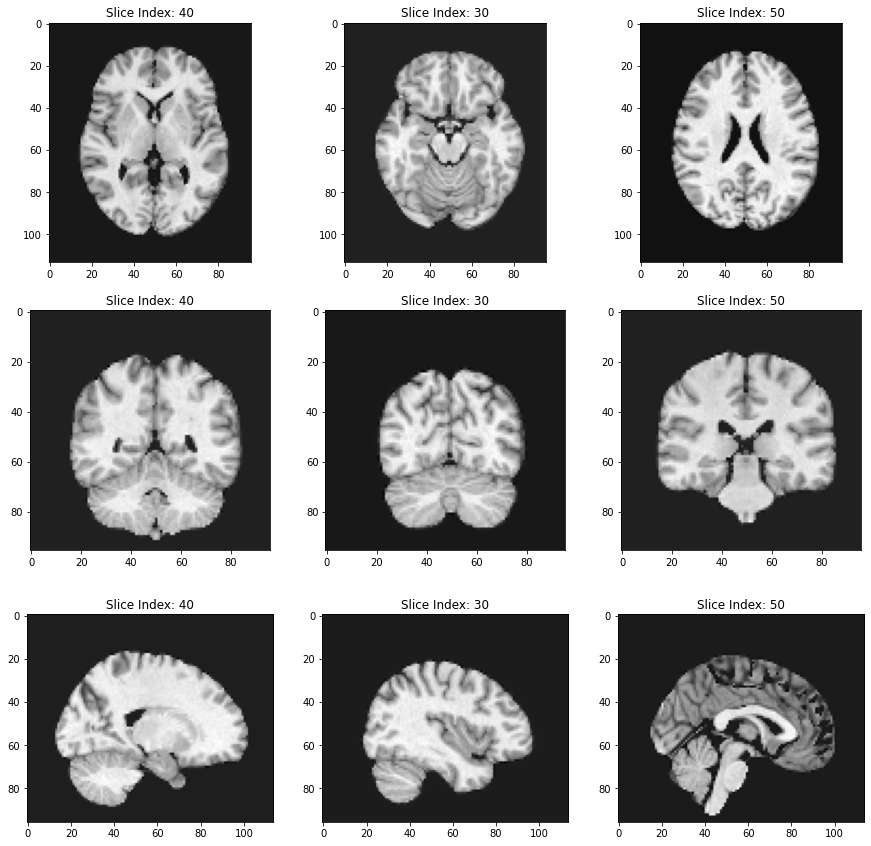

In [12]:
# Define subject and slice indices and visualize results
# NOTE: we are interating of a list of slice indices to emphasize the range of slices
subject_index = 400
slice_indices = [40, 30, 50]


visualize_data(adni_data_train, subject_index, slice_indices)

## Define the classifier

Here we define a class for our model. All models we build for use with torch should be a subclass of the *torch.nn.Module* class. It is the base class for all neural netowrk modules. We define the different layers we want to use in our network in the extended **init** method. **NOTE:** the **forward** method defines the computation performed at every call and should be overridden by all subclasses.

In [13]:
class SixtyFourNet(nn.Module):
    """Class for defining a Network architecture. Inherits from the torch neural network module class.
    
    Parameters
    ----------
    drp_rate
        The drop out rate used for regulariztion during training.
        
    Methods
    -------
    encode
        This is where we define the pipeline through which the data is processed in our network.
    forward
        Defines the forward computation at every call.
    flatten
        Flattens the data for use with the last linear transformation layers.
        
    """
    def __init__(self, drp_rate=0.3, print_size=False):
        """Initialization Process."""
        super(SixtyFourNet, self).__init__()
        self.drp_rate = drp_rate
        self.print_size = print_size
        self.dropout = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=2, padding=0)
        self.Conv_3 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_5 = nn.Conv3d(64, 36, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=4, stride=2, padding=0)
        self.classifier = nn.Sequential(
            nn.Linear(1296, 80),
            nn.Sigmoid(),
            nn.Linear(80, 1)
        ) 
        # NOTE: The loss function we use later on was chosen because it is more a more stable 
        #       function. As a result, we need to leave out the last activation function, or output  
        #       layer, of our net so that output is compatible with our chosen loss function.

    def encode(self, x):
        """Network architecture definition.
        
        Parameters
        ----------
        x
            Input data.
        print_size
            Option to print the shape of each layer.
        
        Returns
        -------
        h
            The output after the convolutional layers are applied.
        
        """
        if self.print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.dropout(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if self.print_size:
            print(x.shape)
        h = self.dropout(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if self.print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        if self.print_size:
            print(x.shape)
        x = F.elu(self.Conv_5(x))
        if self.print_size:
            print(x.shape)
        h = self.dropout(self.pool_4(x))
        if self.print_size:
            print(h.shape)
        
        return h

    def forward(self, x):
        """Forward pass.
        
        Parameters
        ----------
        x
            Input data.
        
        Returns
        -------
        x
            The output of a network after the convolutions, flattening and linear classifiers
            
        """
        x = self.encode(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x
    
    def flatten(self, x):
        """Flattens data at the end of the convolutions.
        
        Parameters
        ----------
        x
            Input data.
        
        Returns
        -------
            The flattened array.
            
        """
        # NOTE: Here the view method for Tensors acts like the reshape method in numpy.
        #       Linear layers expect an n x d (sample x flattened inputs) vector.
        return x.view(x.size(0), -1)

In [14]:
# Instantiate our model, specify the use of CUDA with appropriate GPU 
# and check out the number of parameters using count_parameters imported from nitorch
net = SixtyFourNet().cuda(gpu)
print(f"Trainable model parameters: {count_parameters(net)}")

Trainable model parameters: 499845


## Training the Classifier

In this example, we will perform training of our model over multiple trials.

Below we define a function that will run the training of our model. Within this function, we make use of the *Trainer* class imported from nitorch. We use callbacks imported from nitorch in order to keep track of the training progress of our model and to perform early stopping. The *Trainer* class has a method **train_model** which we then use to train our model. After training the model, we use the **visualize_training** and **evaluate_model** functions to evaluate it after each trial. **NOTE:** the **visualize_training** and **evaluate_model** functions imported from nitorch use numpy. Numpy is only supported on the CPU and thus we have to explicitely copy our model to the CPU, since it was trained on the GPU, before we can use the imported functions.

**Machine Learning Note:**

When evaluating a model, it is good practice to do so using a validation set. This allows us to:

- fine tune the model by conducting a search over hyperparameters; which helps in finding an optimal model. 
- run multiple trials in order to find a best performing model as well as analyse the spread of performances.
- maintain model inference fidelity as we still have a test set with which we can evaluate the models.

It is important that we do not use the test set when conducting fine tuning and preliminary analysis of our model. This ensures that our model generalizes well and we do not report false metrics.

In [33]:
def record_metrics(trial_metrics, best_metric, report, retain_metric):
    """Returns appended arrays of metrics.
    
    Parameters
    ----------
    trial_metrics
        List of trial metrics.
    best_metrics
        List of trial-wise best metrics.
    report
        Report output from the train_model method.
    retain_metric
        The metric to record.
        
    Returns
    -------
    trial_metrics
        Appended list of trial metrics.
    best_metrics
        Appended list of trial-wise best metrics.
    """
    # append validation score of the retain metric
    if isinstance(retain_metric, str):
        trial_metrics.append(report["val_metrics"][retain_metric][-1])
        best_metric.append(np.max(report["val_metrics"][retain_metric]))
    else:
        trial_metrics.append(report["val_metrics"][retain_metric.__name__][-1])
        best_metric.append(np.max(report["val_metrics"][retain_metric.__name__]))
    
    return trial_metrics, best_metric


def load_data_into_loader(train_data, val_data, b):
    """Trains a model over epochs and trials and outputs the results.
    
    Parameters
    ----------
    train_data
        Training set; subclass of Dataset.
    val_data
        Validation set; subclass of Dataset.
    b
        Batch size.
    
    Returns
    -------
    train_loader
        loaded training data; subset of DataLoader
    val_loader
        loaded validation data; subset of DataLoader
        
    """
    train_loader = DataLoader(
        train_data, batch_size=b, num_workers=8, shuffle=True
    )
    val_loader = DataLoader(
        val_data, batch_size=1, num_workers=1, shuffle=True
    )
    return train_loader, val_loader


def reset_params_criterion_loss(net):
    """Resets hyperparameters, stopping criterion (loss function), and optimizer.
    
    Parameters
    ----------
    net
        current net for given trial.
    
    Returns
    -------
    criterion
        stopping criterion
    optimizer
        optimization algorithm
    """
    # Optimizer parameters; can also vary these
    lr = 1e-4
    wd = 1e-4
    criterion = nn.BCEWithLogitsLoss().cuda(gpu)
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    return net, criterion, optimizer
    

def smart_name_checkpoints(callbacks, initial_prepend, trial):
    """Add prepend and trial number to the model checkpoint names.
    
    Parameters
    ----------
    callbacks
        Callbacks used during training.
    initial_prepend
        text to prepend to the model checkpoints.
    trial
        trial number.
        
    Returns
    -------
    None

    """
    if callbacks is not None:
        for idx, callback in enumerate(callbacks):
            if isinstance(callback, ModelCheckpoint):
                if initial_prepend is None:
                    initial_prepend = callbacks[idx].prepend
                callbacks[idx].prepend = initial_prepend + "trial_{}_".format(trial)
    

def model_fit(
    network,
    train_data,
    val_data,
    callbacks=[],
    metrics=[],
    trials=None,
    b=4,
    num_epochs=35,
    retain_metric=None,
    show_train_steps=20,
    show_validation_epochs=1
    
):      
    """Trains a model over epochs and trials and outputs the results.
    
    Parameters
    ----------
    network
        The custom network class.
    train_data
        Training set; subclass of Dataset.
    val_data
        Validation set; subclass of Dataset.
    callbacks
        Callbacks used during training.
    metrics
        The metrics used to evaluate the model during training.
    trials
        Number of trials.
    b
        Batch size.
    num_epochs
        Number of epochs per trial.
    retain_metric
        The metric we wish to retain after each trial.
    show_train_steps
        Print loss every show_train_steps steps.
    show_validation_epochs
        Print loss, accuracy and metrics every show_validation_epochs epochs.
        
    Returns
    -------
    best_metric
        List of best metrics from each trial.
    trial_metrics
        List of metrics of model chosen from each trial.
    models
        List of models chosen with lowest loss from each trial.
    """
    trial_metrics = []
    best_metric = []
    models = []
    initial_prepend = None
    net = network().cuda(gpu)
    
    for trial in range(trials):
        print("Starting trial {}".format(trial))

        # add current trial number to model checkpoint path 
        smart_name_checkpoints(callbacks, initial_prepend, trial)
        # TODO: maybe keep this callbacks part for another tutorial, mention smart naming etc, maybe functionize
#         if callbacks is not None:
#             for idx, callback in enumerate(callbacks):
#                 if isinstance(callback, ModelCheckpoint):
#                     if initial_prepend is None:
#                         initial_prepend = callbacks[idx].prepend
#                     callbacks[idx].prepend = initial_prepend + "trial_{}_".format(trial)

        # restart model
        del net
        net = network().cuda(gpu)
        
        # reset hyperparameters, stopping criterion (loss function), and optimizer
        net, criterion, optimizer = reset_params_criterion_loss(net)
        # TODO: should we remove from function?
#         lr = 1e-4
#         wd = 1e-4
#         criterion = nn.BCEWithLogitsLoss().cuda(gpu)
#         optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
        
        # load data for training
        train_loader, val_loader = load_data_into_loader(train_data, val_data, b)
        # TODO: should we remove from function?
#         train_loader = DataLoader(
#             train_data, batch_size=b, num_workers=8, shuffle=True
#         )
#         val_loader = DataLoader(
#             val_data, batch_size=1, num_workers=1, shuffle=True
#         )

        trainer = Trainer(
            net,
            criterion,
            optimizer,
            metrics=metrics,
            callbacks=callbacks,
            device=gpu,
            prediction_type="binary"
        )
        
        # train model and store results
        net, report = trainer.train_model(
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            show_train_steps=show_train_steps,
            show_validation_epochs=show_validation_epochs,
        )
        
        trial_metrics, best_metric = record_metrics(
            trial_metrics, best_metric, report, retain_metric
        )
        models.append(net)
        print("Finished Trial.")
        
        # convert model and trainer device to cpu for use with numpy and visualize results
        cpu = torch.device("cpu")
        trainer.model.to(cpu)
        trainer.device = cpu
        trainer.visualize_training(report, metrics)
        trainer.evaluate_model(val_loader, gpu)

    return best_metric, trial_metrics, models

**NOTE:** Remember to define your own path to a directory where you would like to save the results. Otherwise you run the risk of overwritting data that is not yours.

**Machine Learning Note:**

We can use a technique called early stopping to stop training our model if we see that it no longer continues to improve or it starts to deteriorate in performance as we iterate over epochs. The *EarlyStopping* class from the nitorch library allows us to implement this technique fairly seemlessly using arguments passed in during instantiation to give us control when and why we want to stop.

In [34]:
output_dir = "/ritter/share/projects/konstantine/nitorch_tut"

In [35]:
# Define the variables we want to pass into the model_fit function
trials=3
num_epochs = 50
ignore_epochs = 5
retain_metric = binary_balanced_accuracy
metrics = [binary_balanced_accuracy]
callbacks = [
    EarlyStopping(patience=8, ignore_before=ignore_epochs, retain_metric="loss", mode='min'),
    ModelCheckpoint(
        path=output_dir, store_best=True, ignore_before=ignore_epochs, retain_metric=retain_metric
    )
]

Starting trial 0
[0,    20] loss: 0.65706
[0,    40] loss: 0.68680
[0,    60] loss: 0.69578
[0,    80] loss: 0.69739
[0,   100] loss: 0.69938
[0,   120] loss: 0.69842
[0,   140] loss: 0.70681
[0,   160] loss: 0.70696
Time elapsed: 0h:1m:35s
train binary_balanced_accuracy: 58.03 %
val loss: 0.72787
val binary_balanced_accuracy: 50.00 %
[1,    20] loss: 0.71047
[1,    40] loss: 0.70559
[1,    60] loss: 0.70048
[1,    80] loss: 0.69644
[1,   100] loss: 0.69561
[1,   120] loss: 0.69292
[1,   140] loss: 0.69461
[1,   160] loss: 0.69622
Time elapsed: 0h:3m:11s
train binary_balanced_accuracy: 68.12 %
val loss: 0.72783
val binary_balanced_accuracy: 50.00 %
[2,    20] loss: 0.74279
[2,    40] loss: 0.71796
[2,    60] loss: 0.71305
[2,    80] loss: 0.70749
[2,   100] loss: 0.70317
[2,   120] loss: 0.70235
[2,   140] loss: 0.70332
[2,   160] loss: 0.70284
Time elapsed: 0h:4m:58s
train binary_balanced_accuracy: 46.19 %
val loss: 0.68719
val binary_balanced_accuracy: 47.92 %
[3,    20] loss: 0.7002

[25,    60] loss: 0.47949
[25,    80] loss: 0.44067
[25,   100] loss: 0.42801
[25,   120] loss: 0.40560
[25,   140] loss: 0.39850
[25,   160] loss: 0.38275
Time elapsed: 0h:42m:46s
train binary_balanced_accuracy: 78.75 %
val loss: 0.36674
val binary_balanced_accuracy: 83.33 %
[26,    20] loss: 0.55779
[26,    40] loss: 0.43754
[26,    60] loss: 0.42310
[26,    80] loss: 0.39804
[26,   100] loss: 0.37920
[26,   120] loss: 0.37607
[26,   140] loss: 0.36904
[26,   160] loss: 0.36408
Time elapsed: 0h:44m:32s
train binary_balanced_accuracy: 89.52 %
val loss: 0.36415
val binary_balanced_accuracy: 83.33 %
[27,    20] loss: 0.52248
[27,    40] loss: 0.41489
[27,    60] loss: 0.36754
[27,    80] loss: 0.32279
[27,   100] loss: 0.31746
[27,   120] loss: 0.31005
[27,   140] loss: 0.32530
[27,   160] loss: 0.32519
Time elapsed: 0h:46m:10s
train binary_balanced_accuracy: 87.01 %
val loss: 0.38119
val binary_balanced_accuracy: 83.75 %
Early stopping at epoch 27.
Best model was at epoch 19 with val m

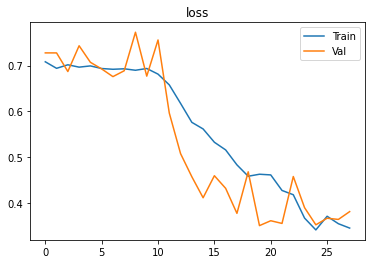

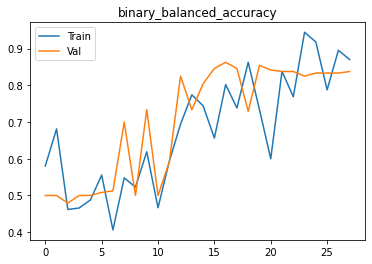

eval loss: 0.38119
eval binary_balanced_accuracy: 83.75 %
Starting trial 1
[0,    20] loss: 0.68607
[0,    40] loss: 0.69178
[0,    60] loss: 0.69327
[0,    80] loss: 0.69232
[0,   100] loss: 0.69214
[0,   120] loss: 0.69311
[0,   140] loss: 0.69415
[0,   160] loss: 0.69444
Time elapsed: 0h:1m:19s
train binary_balanced_accuracy: 60.95 %
val loss: 0.67586
val binary_balanced_accuracy: 50.00 %
[1,    20] loss: 0.70061
[1,    40] loss: 0.70466
[1,    60] loss: 0.69990
[1,    80] loss: 0.69826
[1,   100] loss: 0.69845
[1,   120] loss: 0.69695
[1,   140] loss: 0.69730
[1,   160] loss: 0.69694
Time elapsed: 0h:3m:13s
train binary_balanced_accuracy: 42.53 %
val loss: 0.70510
val binary_balanced_accuracy: 50.00 %
[2,    20] loss: 0.69847
[2,    40] loss: 0.70314
[2,    60] loss: 0.70177
[2,    80] loss: 0.70163
[2,   100] loss: 0.69972
[2,   120] loss: 0.69848
[2,   140] loss: 0.69832
[2,   160] loss: 0.69782
Time elapsed: 0h:4m:41s
train binary_balanced_accuracy: 33.33 %
val loss: 0.71650
val

In [ ]:
# Call the model_fit function and print the mean and std of the metrics over all trials
best_metric, trial_metrics, models = model_fit(
    network=SixtyFourNet, 
    train_data=adni_data_train, 
    val_data=adni_data_val,
    callbacks=callbacks,
    metrics=metrics,
    trials=trials,
    b=b,
    num_epochs=num_epochs,
    retain_metric=retain_metric,
    show_train_steps=20,
    show_validation_epochs=1
)
print("################################")
print("################################")
print(f"Trial-wise Chosen Epoch Accuracies: {np.round(trial_metrics, decimals=4)}")
print(
    f"Trial-wise Mean and Standard Deviation: {np.round(np.mean(trial_metrics), decimals=4)}" + \
    u" \u00B1 " + f"{np.round(np.std(trial_metrics), decimals=4)}"
)
print(f"Trial-wise Best Accuracies: {np.round(best_metric, decimals=4)}")
print(
    f"Trial-wise Best Accuracies Mean and Standard Deviation: {np.round(np.mean(best_metric), decimals=4)}" + \
    u" \u00B1 " + f"{np.round(np.std(trial_metrics), decimals=4)}"
)


## Start inference

### Using best model checkpoint for inference

Now that we have saved the models from each trial, we can load them and evaluate their performance on the test set.

In [ ]:
test_loader = DataLoader(
            adni_data_test, batch_size=1, num_workers=1, shuffle=True
)

In [ ]:
model_dirs = [os.path.join(output_dir,f"trial_{i}_BEST_ITERATION.h5") for i in range(trials)]

In [ ]:
def print_roc_and_auc(fpr, tpr, roc_auc, lw=2):
    """Displays the receiver operating characteristic curve for a given classifier.
    
    Parameters
    ----------
    fpr
        false positive rate
    tpr
        true positive rate
    roc_auc
        area under the (ROC) curve; AUC
    lw
        linewidth
    
    Returns
    -------
    None      
    
    """
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


def evaluate_models(test_loader, model_dirs, network):
    """Evaluates a group of models and prints the respective binary classification 
       accuracy, specificity, and sensitivity as well as the ROC curves.
       
    Parameters
    ----------
    
    test_loader
        loaded test set using torch's DataLoader class
    model_dirs
        list of dirs where the best performing models from each trial was stored
    network
        network class used for classification
        
    Returns
    -------
    None
    
    """
    metrics = []

    for trial, model_dir in enumerate(model_dirs):
        print(f"Trial {trial}")

        pred_score = []
        all_preds = []
        all_labels = []
        net = network().cuda(gpu)
        net.load_state_dict(torch.load(model_dir))
        
        # set net to evaluation mode so that batchnorm and dropout layers are in eval mode
        net.eval()
        # no_grad() deactivates the auto-gradient calculations which speeds up computation
        # during classification.(no backprop)
        with torch.no_grad():
            for sample in test_loader:
                img = sample["image"]
                label = sample["label"]

                img = img.to(torch.device("cuda:" + str(gpu)))

                output = net.forward(img)
                pred_score.append(torch.sigmoid(output).cpu())
                # NOTE: As mentioned ealier, our last layer is linear, and so we need to send it
                #       through a sigmoid and then threshold the output to convert it to binary
                #       labels.
                pred = torch.sigmoid(output) >= 0.5
                all_preds.append(pred.cpu().numpy().item())
                all_labels.append(label.numpy().item())

        balanced_acc = binary_balanced_accuracy(all_labels, all_preds)
        specif = specificity(all_labels, all_preds)
        sensi = sensitivity(all_labels, all_preds)
        print(f"Balanced Accuracy: {balanced_acc}")
        print(f"Specificity: {specif}")
        print(f"Sensitivity: {sensi}\n")
        # NOTE: The roc_curve function from sklearn uses true labels and the pred_score. This
        #       means it needs the non thresholded output of the last layer.
        fpr, tpr, _ = roc_curve(all_labels, pred_score)
        roc_auc = auc(fpr, tpr)
        print_roc_and_auc(fpr, tpr, roc_auc)
        # Here we set the net back to training mode before moving on to the next net to evaluate.
        net.train()
        metrics.append([balanced_acc, specif, sensi])
    metrics = np.array(metrics)
    print("######## Final results ########")
    print(f"Binary balanced accuracy mean: {np.mean(metrics[:, 0])*100:.2f} %")
    print(f"Specificity mean: {np.mean(metrics[:, 1])*100:.2f} %")
    print(f"Sensitivity mean: {np.mean(metrics[:, 2])*100:.2f} %")

In [ ]:
evaluate_models(test_loader, model_dirs, SixtyFourNet)